Notes: TD(lambda) is going to look similar to mc, since it requires a full trace experience to perform an update. However, we can place different weights based on the recency of visits to a particular state? 

lambda = 0 : TD(0)

lambada = 1 : MC

In [3]:
import rl.markov_process as mp
import numpy as np
from rl.function_approx import Gradient
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.function_approx import Tabular
from rl.monte_carlo import *

### From RL-Book:

In [4]:
def tabular_td_lambda_prediction(
        traces: Iterable[Iterable[mp.TransitionStep[S]]],
        approx_0: Tabular[S],
        gamma: float,
        lambd: float
) -> Iterator[Tabular[S]]:
    # Initial approximation
    func_approx: Tabular[S] = approx_0
    # yield this initial approximation
    yield func_approx
    
    # For each trace experience:
    for trace in traces:
        el_tr: Gradient[Tabular[S]] = Gradient(func_approx).zero()
        # For each atomic experience:
        for step in trace:
            x: NonTerminal[S] = step.state
            y: float = step.reward + gamma * \
                extended_vf(func_approx, step.next_state)
            el_tr = el_tr * (gamma * lambd) + func_approx.objective_gradient(
                xy_vals_seq=[(x, y)],
                obj_deriv_out_fun=lambda x1, y1: np.ones(len(x1))
            )
            func_approx = func_approx.update_with_gradient(
                el_tr * (func_approx(x) - y)
            )
            yield func_approx

In [5]:
def td_lambda_prediction(
        traces: Iterable[Iterable[mp.TransitionStep[S]]],
        approx_0: ValueFunctionApprox[S],
        gamma: float,
        lambd: float
) -> Iterator[ValueFunctionApprox[S]]:
    func_approx: ValueFunctionApprox[S] = approx_0
    yield func_approx
    for trace in traces:
        el_tr: Gradient[ValueFunctionApprox[S]] = Gradient(func_approx).zero()
        for step in trace:
            x: NonTerminal[S] = step.state
            y: float = step.reward + gamma * \
                extended_vf(func_approx, step.next_state)
            el_tr = el_tr * (gamma * lambd) + func_approx.objective_gradient(
                xy_vals_seq=[(x, y)],
                obj_deriv_out_fun=lambda x1, y1: np.ones(len(x1))
            )
            func_approx = func_approx.update_with_gradient(
                el_tr * (func_approx(x) - y)
            )
            yield func_approx

## Testing

In [6]:
from rl.monte_carlo import *
from rl.td import *
from rl.chapter2.simple_inventory_mrp import *
from rl.function_approx import Tabular
from rl.distribution import Constant
import rl.iterate as iterate

In [7]:
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0

user_gamma = 0.9

si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)

In [8]:
# Correct Value Function:

print("Value Function")
print("--------------")
si_mrp.display_value_function(gamma=user_gamma)
print()

Value Function
--------------
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345}



In [9]:
from rl.chapter10.prediction_utils import *

In [23]:
true_vf = si_mrp.get_value_function_vec(gamma=user_gamma)

In [17]:
# MC

mc_dist = Constant(NonTerminal(InventoryState(0,0)))
mc_trace_experiences = si_mrp.reward_traces(mc_dist)

mc_approx = Tabular()
mc_value_functs = mc_prediction(mc_trace_experiences, mc_approx, user_gamma)

v_num = 0
num_iterations = 20000
processed_value_funcs_mc = []
for i in mc_value_functs:
    processed_value_funcs_mc += [i]
    v_num += 1
    if v_num > num_iterations:
        break

In [18]:
# TD
td_dist = Constant(NonTerminal(InventoryState(0,0)))
td_trace_experiences = si_mrp.simulate_reward(td_dist)

from rl.function_approx import learning_rate_schedule
initial_learning_rate = 0.03
H = 1000
exponent  = 0.5

learning_rate_func = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=H,
    exponent=exponent)

td_approx = Tabular(count_to_weight_func=learning_rate_func)
td_value_functs = td_prediction(td_trace_experiences, td_approx, user_gamma)

v_num = 0
num_iterations = 20000
processed_value_funcs_td = []
for i in td_value_functs:
    processed_value_funcs_td += [i]
    v_num += 1
    if v_num > num_iterations:
        break

In [44]:
# TD-Lambda 0.5

tdl_dist = Constant(NonTerminal(InventoryState(0,0)))
tdl_trace_experiences = si_mrp.reward_traces(tdl_dist)

learning_rate_func = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=H,
    exponent=exponent)


tdl_approx = Tabular(count_to_weight_func=learning_rate_func)
tdl_value_functs = td_lambda_prediction(tdl_trace_experiences, tdl_approx, user_gamma, 0.5)

v_num = 0
num_iterations = 20000
processed_value_funcs_tdl05 = []
for i in tdl_value_functs:
    processed_value_funcs_tdl05 += [i]
    v_num += 1
    if v_num > num_iterations:
        break

In [45]:
# TD-Lambda 0.3

tdl_dist = Constant(NonTerminal(InventoryState(0,0)))
tdl_trace_experiences = si_mrp.reward_traces(tdl_dist)

learning_rate_func = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=H,
    exponent=exponent)


tdl_approx = Tabular(count_to_weight_func=learning_rate_func)
tdl_value_functs = td_lambda_prediction(tdl_trace_experiences, tdl_approx, user_gamma, 0.3)

v_num = 0
num_iterations = 20000
processed_value_funcs_tdl03 = []
for i in tdl_value_functs:
    processed_value_funcs_tdl03 += [i]
    v_num += 1
    if v_num > num_iterations:
        break

In [46]:
# TD-Lambda 0.7

tdl_dist = Constant(NonTerminal(InventoryState(0,0)))
tdl_trace_experiences = si_mrp.reward_traces(tdl_dist)

learning_rate_func = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=H,
    exponent=exponent)


tdl_approx = Tabular(count_to_weight_func=learning_rate_func)
tdl_value_functs = td_lambda_prediction(tdl_trace_experiences, tdl_approx, user_gamma, 0.7)

v_num = 0
num_iterations = 20000
processed_value_funcs_tdl07 = []
for i in tdl_value_functs:
    processed_value_funcs_tdl07 += [i]
    v_num += 1
    if v_num > num_iterations:
        break

In [47]:
processed_value_funcs_mc[-1]

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.48821473361368, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.31933830305567, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.31323235705847, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.91191399510026, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.321822325742943, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.92934076429053}, counts_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 323200, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 320929, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 423448, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 423785, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 414928, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 713710}, count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7fad1145d5e0>)

In [48]:
processed_value_funcs_td[-1]

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.0920196766914, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -27.719408638296574, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.815091827543668, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.645037117744685, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.127270090981874, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -29.90762772169935}, counts_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 2357, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 2357, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 3234, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 5553, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 3234, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 3265}, count_to_weight_func=<function learning_rate_schedule.<locals>.lr_func at 0x7fad119be310>)

In [49]:
processed_value_funcs_tdl05[-1]

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.55228669757933, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.467003564568973, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -29.04882973993108, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.652169445277288, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.65286670805174, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -28.13102892165675}, counts_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 2344, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 2344, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 3229, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 3228, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 3423, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 5432}, count_to_weight_func=<function learning_rate_schedule.<locals>.lr_func at 0x7fad18959d30>)

## Calculate RMSE

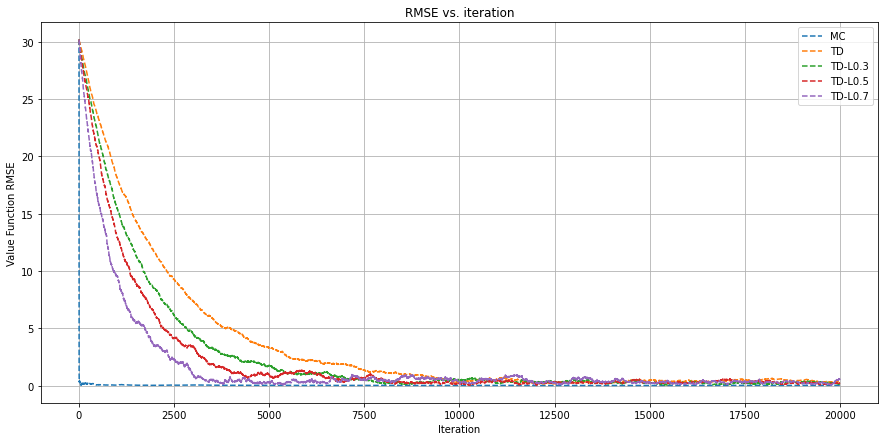

In [51]:
from matplotlib import pyplot as plt
states: Sequence[NonTerminal[S]] = si_mrp.non_terminal_states
plot_start = 0
plt.figure(figsize=(15,7))

# MC
mc_errors = []
for i, mc_f in enumerate(processed_value_funcs_mc):
    
    mc_errors.append(sqrt(sum(
        (mc_f(s) - true_vf[j]) ** 2 for j, s in enumerate(states)
    ) / len(states))) 
mc_plot = mc_errors[plot_start:]
plt.plot(
    range(len(mc_plot)),
    mc_plot,
    linestyle='--'
)


# TD
td_errors = []
for i, td_f in enumerate(processed_value_funcs_td):
    
    td_errors.append(sqrt(sum(
        (td_f(s) - true_vf[j]) ** 2 for j, s in enumerate(states)
    ) / len(states)))
td_plot = td_errors[plot_start:]
plt.plot(
    range(len(td_plot)),
    td_plot,
    linestyle='--'
)


# TD-lambda03
tdl_errors03 = []
for i, tdl_f in enumerate(processed_value_funcs_tdl03):
    
    tdl_errors03.append(sqrt(sum(
        (tdl_f(s) - true_vf[j]) ** 2 for j, s in enumerate(states)
    ) / len(states)))
tdl_plot03 = tdl_errors03[plot_start:]
plt.plot(
    range(len(tdl_plot03)),
    tdl_plot03,
    linestyle='--'
)

# TD-lambda05
tdl_errors05 = []
for i, tdl_f in enumerate(processed_value_funcs_tdl05):
    
    tdl_errors05.append(sqrt(sum(
        (tdl_f(s) - true_vf[j]) ** 2 for j, s in enumerate(states)
    ) / len(states)))
tdl05_plot = tdl_errors05[plot_start:]
plt.plot(
    range(len(tdl05_plot)),
    tdl05_plot,
    linestyle='--'
)

# TD-lambda07
tdl_errors07 = []
for i, tdl_f in enumerate(processed_value_funcs_tdl07):
    
    tdl_errors07.append(sqrt(sum(
        (tdl_f(s) - true_vf[j]) ** 2 for j, s in enumerate(states)
    ) / len(states)))
tdl_plot07 = tdl_errors07[plot_start:]
plt.plot(
    range(len(tdl_plot07)),
    tdl_plot07,
    linestyle='--'
)




plt.xlabel("Iteration")
plt.ylabel("Value Function RMSE")
plt.title(
    "RMSE vs. iteration"
)
plt.grid(True)
plt.legend(["MC", "TD", "TD-L0.3", "TD-L0.5", "TD-L0.7"])
plt.show()